<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Мы имеем задачу бинарной классификации. В исследовании будут использоваться 3 модели ML: дерево решений, случайный лес и логистическая регрессия.

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
np.random.seed(0)

In [6]:
data = pd.read_csv('Churn.csv')

In [7]:
data.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9394,9395,15615753,Upchurch,597,Germany,Female,35,8.0,131101.04,1,1,1,192852.67,0
898,899,15654700,Fallaci,523,France,Female,40,2.0,102967.41,1,1,0,128702.10,1
2398,2399,15633877,Morrison,706,Spain,Female,42,8.0,95386.82,1,1,1,75732.25,0
5906,5907,15745623,Worsnop,788,France,Male,32,4.0,112079.58,1,0,0,89368.59,0
2343,2344,15765902,Gibson,706,Germany,Male,38,5.0,163034.82,2,1,1,135662.17,0


Целевой признак - Exited. (1 - уход клиента / 0 - клиент остался)

Такие признаки как RowNumber (Индекс строки), CustomerId (Уникальный идентификатор) и Surname (Фамилия) не несут абсолютно никакой смысловой нагрузки для обучения модели. Для того, чтобы модель не выявила ложной корреляции, удалим эти признаки.

Изменения внесем в копию!

In [8]:
data_new = data.copy(deep=True)
data_new = data_new.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [9]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Здесь видно, что атрибут Tenure (сколько лет человек является клиентом банка) имеет около 10% пропусков.

1.0     0.104719
2.0     0.104499
8.0     0.102629
3.0     0.102079
5.0     0.101969
7.0     0.101749
4.0     0.097349
9.0     0.097019
6.0     0.096909
10.0    0.049060
0.0     0.042020
Name: Tenure, dtype: float64

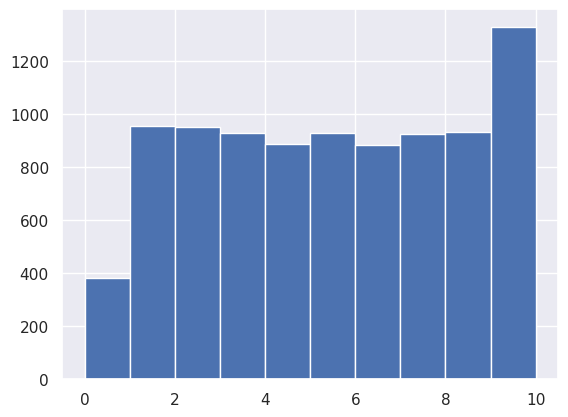

In [10]:
data_new['Tenure'].hist(grid=True,bins=10)
data_new['Tenure'].value_counts(normalize=True,sort=True)

In [11]:
data_new.corr().loc['Tenure']

CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
Name: Tenure, dtype: float64

Так как данные атрибута Tenure не имеют значительной корреляции с другими атрибутами и очевидно, что эти данные пропущены не случайно - можно сделать вывод, что они имееют корреляцию с неизвестными нам факторами. Поэтому простое удаление исказит статистические свойства выборки. Заполним случайными значениями пропуски.

In [12]:
import random
data_new["Tenure"] = data_new["Tenure"].apply(lambda x: x if not np.isnan(x) else np.random.randint(0,11))

In [13]:
data_new["Tenure"].isnull().value_counts()

False    10000
Name: Tenure, dtype: int64

Также два признака Geography и Gender являются категориальными. Для правильного обучения логистической регрессии нужно применить прямое кодирование OHE.

In [14]:
data_new["Gender"].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [15]:
data_new["Geography"].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [16]:
data_new_ohe = pd.get_dummies(data_new,columns=['Gender','Geography'],drop_first=True)

In [17]:
data_new_ohe.tail()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
9995,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,1,0
9999,792,28,7.0,130142.79,1,1,0,38190.78,0,0,0,0


## Исследование задачи

Посмотрим на корреляцию признаков

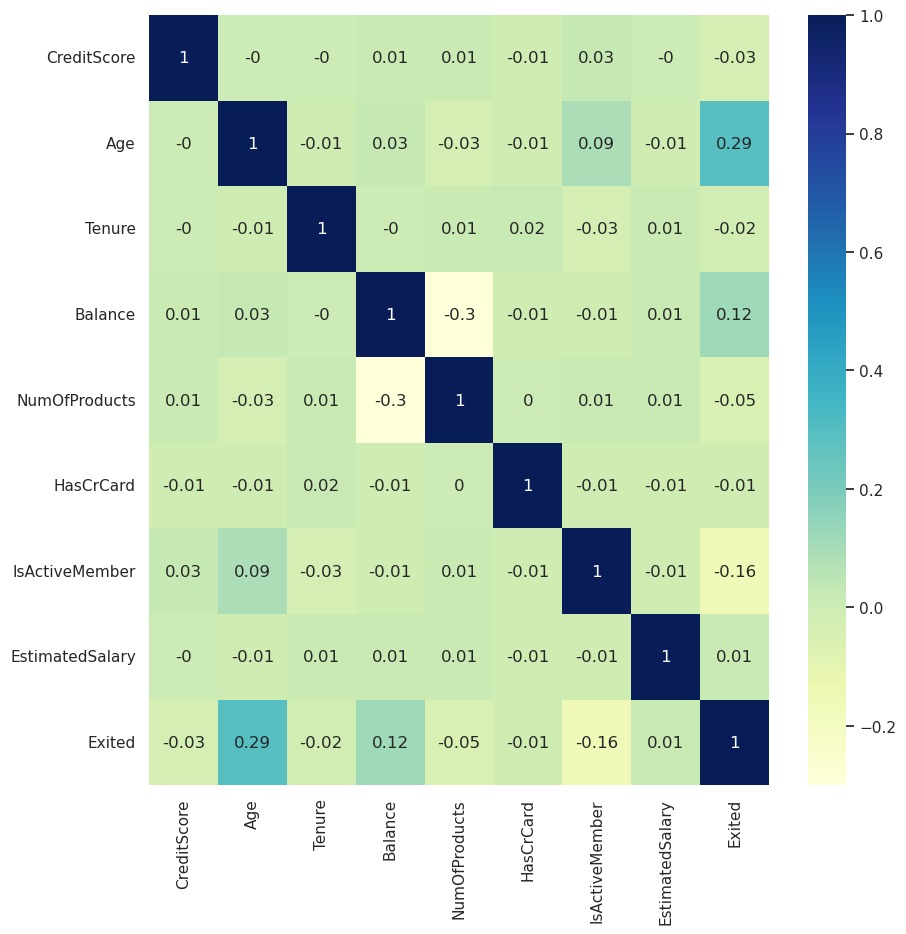

In [18]:
fig,ax = plt.subplots(figsize=(10,10))
data_corr = round(data_new.corr(),2)
corr_plot = sns.heatmap(data_corr, annot=True, cmap='YlGnBu')

В общем корелляция очень слабая; со значением 0.4 коррелирует баланс на счете и клиенты из Германии. Но это не большое значение! Также наблюдается небольшая корелляция между балансом счета и количеством продуктов банка

В данном иследовании - основная цель - исследовать текущих клиентов на возможность ухода из банка. При оценке качества обученных моделей будем использовать 2 основных метрики: f1-score и ROC AUC. Стоит отметить, что F мера более устойчива к дисбалансу классов, чем ROC AUC.

## Борьба с дисбалансом

В данном разделе проверим данные на дисбаланс классов

In [19]:
count_class_0, count_class_1 = data_new.Exited.value_counts()
print(f'0 class {count_class_0}')
print(f'1 class {count_class_1}')

0 class 7963
1 class 2037


Для начала разобьем данные на train и test

In [20]:
df_train, df_test = train_test_split(data_new_ohe,test_size=0.25)
feat_test = df_test.drop(columns=['Exited'],axis=1)
target_test = df_test['Exited']

Проверим дисбаланс в тестовом и тренировочном датафреймах

In [21]:
count_class_0, count_class_1 = df_test.Exited.value_counts()
print('TEST DF')
print(f'0 class {count_class_0}')
print(f'1 class {count_class_1}')

TEST DF
0 class 1993
1 class 507


Дисбаланс классов в тестовых данных есть, их оставляем!

In [22]:
count_class_0, count_class_1 = df_train.Exited.value_counts()
print('TRAIN DF')
print(f'0 class {count_class_0}')
print(f'1 class {count_class_1}')

TRAIN DF
0 class 5970
1 class 1530


Исправим дисбаланс классов в тренировочных данных

In [23]:
data_class_0 = df_train.query('Exited == 0')
data_class_1 = df_train.query('Exited == 1')
data_class_0.shape, data_class_1.shape

((5970, 12), (1530, 12))

In [24]:
data_class_0_under = data_class_0.sample(count_class_1)

In [25]:
data_class_0_under.shape

(1530, 12)

In [26]:
data_train = pd.concat([data_class_1, data_class_0_under],axis=0)
data_train = shuffle(data_train)
feat_train = data_train.drop(columns=['Exited'],axis=1)
target_train = data_train['Exited']

In [27]:
target_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: Exited, dtype: float64

Нужно стандартизировать данные!

In [28]:
cols_to_scale = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
scaler = StandardScaler()
scaler.fit(feat_train[cols_to_scale])
feat_train[cols_to_scale] = scaler.transform(feat_train[cols_to_scale])
feat_test[cols_to_scale] = scaler.transform(feat_test[cols_to_scale])

In [29]:
pd.set_option('display.float_format', lambda x: '%0.4f' % x)
feat_train.describe().loc[['mean','std','max']]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
mean,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.6967,0.4536,0.0000,0.5029,0.2974,0.2441
std,1.0002,1.0002,1.0002,1.0002,1.0002,0.4597,0.4979,1.0002,0.5001,0.4572,0.4296
max,2.0432,4.7964,1.7027,2.5359,3.6991,1.0000,1.0000,1.7297,1.0000,1.0000,1.0000


## Тестирование модели

`Дерево решений`

In [30]:
params = {'max_depth':range(2,20),
         'criterion':['gini','entropy']}
DTC_model = GridSearchCV(DecisionTreeClassifier(),
                         param_grid=params,
                        cv = 5,
                        n_jobs=-1,
                        scoring='f1')
DTC_model.fit(feat_train,target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20)},
             scoring='f1')

In [31]:
DTC_model.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [32]:
f1_score_train = round(DTC_model.best_score_,4)
print(f'F1 мера на тренировочных данных {f1_score_train}')

F1 мера на тренировочных данных 0.7503


In [33]:
predictions_DTC = DTC_model.predict(feat_test)

Теперь проверим результат на тестовых данных!

In [34]:
print(classification_report(target_test, predictions_DTC))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1993
           1       0.45      0.80      0.58       507

    accuracy                           0.77      2500
   macro avg       0.70      0.78      0.71      2500
weighted avg       0.84      0.77      0.78      2500



In [35]:
f1_score_test = round(f1_score(target_test, predictions_DTC),4)
print(f'F1 мера на тестовых данных {f1_score_test}')

F1 мера на тестовых данных 0.5792


- Основная метрика (F1) = 0.5763

`Случайный лес`

In [36]:
params = {'max_depth':range(1,30),
         'n_estimators':range(1,50,2),
         'min_samples_leaf':range(1,6)}
RFC_model = RandomizedSearchCV(RandomForestClassifier(),
                              param_distributions=params,
                              cv=5,
                              n_iter=20,
                              scoring='f1')
RFC_model.fit(feat_train,target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': range(1, 30),
                                        'min_samples_leaf': range(1, 6),
                                        'n_estimators': range(1, 50, 2)},
                   scoring='f1')

In [37]:
RFC_model.best_params_

{'n_estimators': 31, 'min_samples_leaf': 2, 'max_depth': 21}

In [38]:
f1_score_train = round(RFC_model.best_score_,4)
print(f'F1 мера на тренировочных данных {f1_score_train}')

F1 мера на тренировочных данных 0.7632


In [39]:
predictions_RFC = RFC_model.predict(feat_test)
f1_score_test = round(f1_score(target_test, predictions_RFC),4)
print(f'F1 мера на тестовых данных {f1_score_test}')

F1 мера на тестовых данных 0.6065


- Основная метрика (F1) = 0.6199

`Логистическая регрессия`

In [40]:
params = {
    'max_iter':[10,30,50,100,150,500,700],
    'solver':['lbfgs','liblinear'],
     'penalty':['l2']}
LR_model = GridSearchCV(LogisticRegression(),
                        param_grid=params,
                       cv=5,
                       n_jobs=-1,
                       scoring='f1')
LR_model.fit(feat_train,target_train)

/home/crytek/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/crytek/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [10, 30, 50, 100, 150, 500, 700],
                         'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']},
             scoring='f1')

In [41]:
LR_model.best_params_

{'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [42]:
f1_score_train = round(LR_model.best_score_,4)
print(f'F1 мера на тренировочных данных {f1_score_train}')

F1 мера на тренировочных данных 0.7005


In [43]:
predictions_LR = LR_model.predict(feat_test)
f1_score_test = round(f1_score(target_test, predictions_LR),4)
print(f'F1 мера на тестовых данных {f1_score_test}')

F1 мера на тестовых данных 0.5072


- Основная метрика(F1) = 0.5072

***ROC AUC***

In [44]:
#метрика roc_auc
pred_prob_DTC = DTC_model.predict_proba(feat_test)[:,1]
pred_prob_RFC = RFC_model.predict_proba(feat_test)[:,1]
pred_prob_LR = LR_model.predict_proba(feat_test)[:,1]

In [45]:
print(pred_prob_DTC.shape)
pred_prob_DTC

(2500,)


array([0.22082019, 0.        , 0.19433198, ..., 0.41714286, 0.19433198,
       0.73043478])

In [46]:
#код ревьюера
pd.Series(pred_prob_DTC).value_counts()

0.2208    350
0.0186    287
0.1943    250
0.4171    169
0.5882    148
0.7926    142
0.0640    135
0.6915    127
0.1594     85
0.9950     78
0.5100     76
0.7304     72
0.2000     70
1.0000     58
0.4933     45
0.0000     45
0.2909     43
0.8876     37
0.2667     36
0.9697     30
0.2188     29
0.9265     28
0.3500     26
0.5682     24
0.6364     21
0.8696     20
0.9355     17
0.0667     14
0.4444     12
0.3333      9
0.7000      5
0.3750      3
0.7500      3
0.5000      2
0.6667      2
0.2500      2
dtype: int64

In [47]:
roc_auc_DTC = round(roc_auc_score(target_test, pred_prob_DTC),4)
roc_auc_RFC = round(roc_auc_score(target_test, pred_prob_RFC),4)
roc_auc_LR = round(roc_auc_score(target_test, pred_prob_LR),4)

/home/crytek/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'ROC AUC scoring')

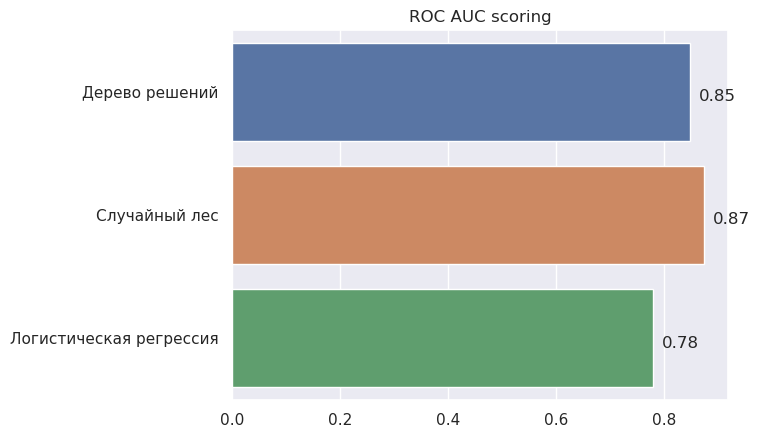

In [48]:
list_names = ['Дерево решений','Случайный лес','Логистическая регрессия']
list_values = [roc_auc_DTC, roc_auc_RFC, roc_auc_LR]

ax = sns.barplot(list_values, list_names)
for i in ax.patches:
    width = i.get_width()
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, round(width,2), ha='center', va='bottom')
ax.set_title('ROC AUC scoring')

In [49]:
fpr_1, tpr_1, threshold_1 = roc_curve(target_test, pred_prob_DTC)
roc_auc_1 = auc(fpr_1, tpr_1)
fpr_2, tpr_2, threshold_2 = roc_curve(target_test, pred_prob_RFC)
roc_auc_2 = auc(fpr_2, tpr_2)
fpr_3, tpr_3, threshold_3 = roc_curve(target_test, pred_prob_LR)
roc_auc_3 = auc(fpr_3,tpr_3)

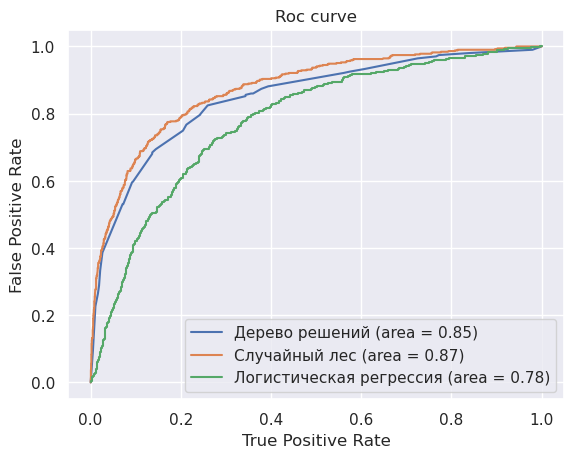

In [50]:
list_fpr = [fpr_1, fpr_2, fpr_3]
list_tpr = [tpr_1, tpr_2, tpr_3]
list_roc_auc = [roc_auc_1,roc_auc_2,roc_auc_3]

fig,ax = plt.subplots()
for fpr, tpr, roc_auc, name in zip(list_fpr, list_tpr,list_roc_auc,list_names):
    ax.plot(fpr,tpr,
           label=f'{name} (area = %0.2f)' % roc_auc)
ax.set_title("Roc curve")
ax.set_xlabel("True Positive Rate")
ax.set_ylabel("False Positive Rate")
ax.legend(loc='best')

## Общий вывод

В результате исследования получили лучшую модель - случайный лес. 

- Метрика F1 мера = 0.6199
- Метрика AUC мера = 0.88

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*